In [35]:
from profiler import Analyser
import pandas as pd
import networkx as nx
import scipy.cluster.hierarchy as sch

from seaborn import heatmap
from sklearn.cluster import SpectralClustering
from sklearn.cluster import SpectralClustering
from sklearn.cluster import KMeans, AffinityPropagation

from matplotlib import colors
from matplotlib.colors import rgb2hex, colorConverter

import os
from collections import defaultdict, Counter
from tqdm import tqdm

from IPython.core.display import display, HTML

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [66]:
def plot_corr(df,size=10):

    # Compute the correlation matrix for the received dataframe
    corr = df.corr()
    
    # Plot the correlation matrix
    fig, ax = plt.subplots(figsize=(size, size))
    cax = ax.matshow(corr, cmap='RdYlGn')
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90);
    plt.yticks(range(len(corr.columns)), corr.columns);
    
    # Add the colorbar legend
    cbar = fig.colorbar(cax, ticks=[-1, 0, 1], aspect=40, shrink=.8)

class Clusters(dict):
    def _repr_html_(self):
        html = '<table style="border: 0;">'
        for c in self:
            hx = rgb2hex(colorConverter.to_rgb(c))
            html += '<tr style="border: 0;">' \
            '<td style="background-color: {0}; ' \
                       'border: 0;">' \
            '<code style="background-color: {0};">'.format(hx)
            html += c + '</code></td>'
            html += '<td style="border: 0"><code>' 
            html += repr(self[c]) + '</code>'
            html += '</td></tr>'

        html += '</table>'

        return html

def draw_clusters(clusters):
    colors= plt.rcParams['axes.prop_cycle'].by_key()['color'] #['r','b','g','m','y']
    html = '<table style="border: 0;">'
    for k, c in clusters.items():
        hx = rgb2hex(colorConverter.to_rgb(colors[k-1]))
        html += '<tr style="border: 0;">' \
        '<td style="background-color: {0}; ' \
                   'border: 0;">' \
        '<code style="background-color: {0};">'.format(hx)
        html += repr(k) + '</code></td>'
        html += '<td style="border: 0"><code>' 
        html += repr(c) + '</code>'
        html += '</td></tr>'

    html += '</table>'
    display(HTML(html))

def get_cluster_classes(den, label='ivl'):
    cluster_idxs = defaultdict(list)
    for c, pi in zip(den['color_list'], den['icoord']):
        for leg in pi[1:3]:
            i = (leg - 5.0) / 10.0
            if abs(i - int(i)) < 1e-5:
                cluster_idxs[c].append(int(i))

    cluster_classes = Clusters()
    for c, l in cluster_idxs.items():
        i_l = [den[label][i] for i in l]
        cluster_classes[c] = i_l

    return cluster_classes

def draw_communities(G, membership):
    pos= nx.spring_layout(G)
    fig, ax = plt.subplots(figsize=(20,20))
    club_dict = defaultdict(list)
    for student, club in enumerate(membership):
        club_dict[club].append(student)
    norm = colors.Normalize(vmin=0, vmax=len(club_dict.keys()))
    colors_= plt.rcParams['axes.prop_cycle'].by_key()['color']# ['r','b','g','m','y']
    for club, members in club_dict.items():
        nx.draw_networkx_nodes(G, pos,
                               nodelist=members,
                               #node_color=cm.jet(norm(club)),
                               node_color=colors_.pop(),
                               node_size=500,
                               alpha=0.9,
                               ax=ax)

    # Draw edges (social connections) and show final plot
    #plt.title("Zachary's Karate Club")
    nx.draw_networkx_edges(G, pos, alpha=0.5, ax=ax)

# Functions

In [109]:
def create_df_interpolated(feature_):
    bpath= '/home/vitor/Documentos/performance_features/analysis/hpc_belgica_v3/'
    programs= [p for p in os.listdir(bpath) if not 'MINI' in p and 'SMALL' not in p]
    programs= sorted(programs)

    df= []
    p_names= []
    for p in tqdm(programs):
        px= Analyser(bpath+p)
        px.df['input_size']= px.df['PERF_COUNT_HW_INSTRUCTIONS']/px.df['MEM_UOPS_RETIRED:ALL_STORES']
        px.df= px.df.dropna()
        try:
            _, y0= px.interpolate(feature=feature_, npoints= 100) #'input_size'
            df.append(list(y0))
            p_names.append(px.name.split('/')[-1])
        except Exception as e:
            print(e, px.name)

    df= pd.DataFrame(np.array(df).T, columns=p_names)
    return df


def find_best_cluster(df):
    metrics= ['braycurtis', 'canberra', 'chebyshev', 'cityblock', 'correlation', 
             'cosine', 'dice', 'euclidean', 'hamming', 'jaccard', 'kulsinski', 
             'mahalanobis', 'matching', 'minkowski', 'rogerstanimoto', 'russellrao', 
             'seuclidean', 'sokalmichener', 'sokalsneath', 'sqeuclidean', 'yule']

    methods= ['single','complete','average','weighted','centroid','median','ward']
    max_score= 0
    best= {'Z':None, 'pdic':None, 'method':None, 'metric':None, 'nc':None}
    for metric in metrics:
        if metric in ['mahalanobis','yule']: continue
        for method in methods:
            for nc in range(2,10):
                d= sch.distance.pdist(df.values, metric)
                Z = sch.linkage(d, method, optimal_ordering=True)
                labels= sch.fcluster(Z,t=nc,criterion='maxclust')
                pdic= defaultdict(list)
                for l, p in zip(labels, df.index):
                    pdic[l].append(p.split('_')[0])
                if len(pdic.values()) < 2: continue
                score= 0
                for k in pdic:
                    count= Counter(pdic[k])
                    count= np.array(list(count.values()))
                    score+= 2*len(count[count==3])
                    score+= len(count[count==2])
                lens= [len(s) for s in pdic.values()]
                #score+=len(pdic.values())
                score/=max(lens)
                if score > max_score:
                    print(metric, method, len(pdic.values()), score)
                    max_score= score
                    best['Z']= Z
                    best['pdic']= pdic
                    best['metric']= metric
                    best['method']= method
                    best['nc']= nc
                #print(pdic)
                #if score >= 22 and nc > 5:

    #                 plt.figure(figsize=(25, 10))
    #                 plt.title('Hierarchical Clustering Dendrogram', fontsize=20)
    #                 plt.xlabel('stock', fontsize=15)
    #                 plt.ylabel('distance', fontsize=15)
    #                 den= dendrogram(Z, leaf_rotation=90., leaf_font_size=8., labels = df.index)
    #                 pylab.yticks(fontsize=15)
    #                 pylab.xticks(rotation=-90, fontsize=15)
    #                 plt.show()
    #                 break
    #         else: continue
    #         break
    #     else: continue
    #     break
    return best

def plot_dendogram(Z, labels_):
    plt.figure(figsize=(25, 10))
    #plt.title('Dendrogram', fontsize=20)
    plt.xlabel('Application', fontsize=25)
    plt.ylabel('Distance', fontsize=25)
    den= sch.dendrogram(Z, leaf_rotation=90., leaf_font_size=8., labels = labels_)
    pylab.yticks(fontsize=15)
    pylab.xticks(rotation=-90, fontsize=15)

def plot_graph(best):
    G=nx.Graph()
    d= sch.distance.pdist(df.values, metric=best['metric'])
    X= sch.distance.squareform(d)+1
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            G.add_edge(i,j,weight=1/X[i,j]) # weight=X[i,j]
    Z= sch.linkage(d, method=best['method'], optimal_ordering=True)
    p_clusters= sch.fcluster(Z,t=best['nc'],criterion='maxclust')
    draw_communities(G,p_clusters)
    draw_clusters(pdic)

# Clusterization by input size

braycurtis single 2 0.6538461538461539
braycurtis single 4 0.6756756756756757
braycurtis single 6 0.6805555555555556
braycurtis complete 3 0.7741935483870968
braycurtis complete 6 0.9166666666666666
braycurtis ward 3 0.9245283018867925
braycurtis ward 4 0.972972972972973
braycurtis ward 6 1.2307692307692308
canberra ward 5 1.3076923076923077


/home/vitor/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


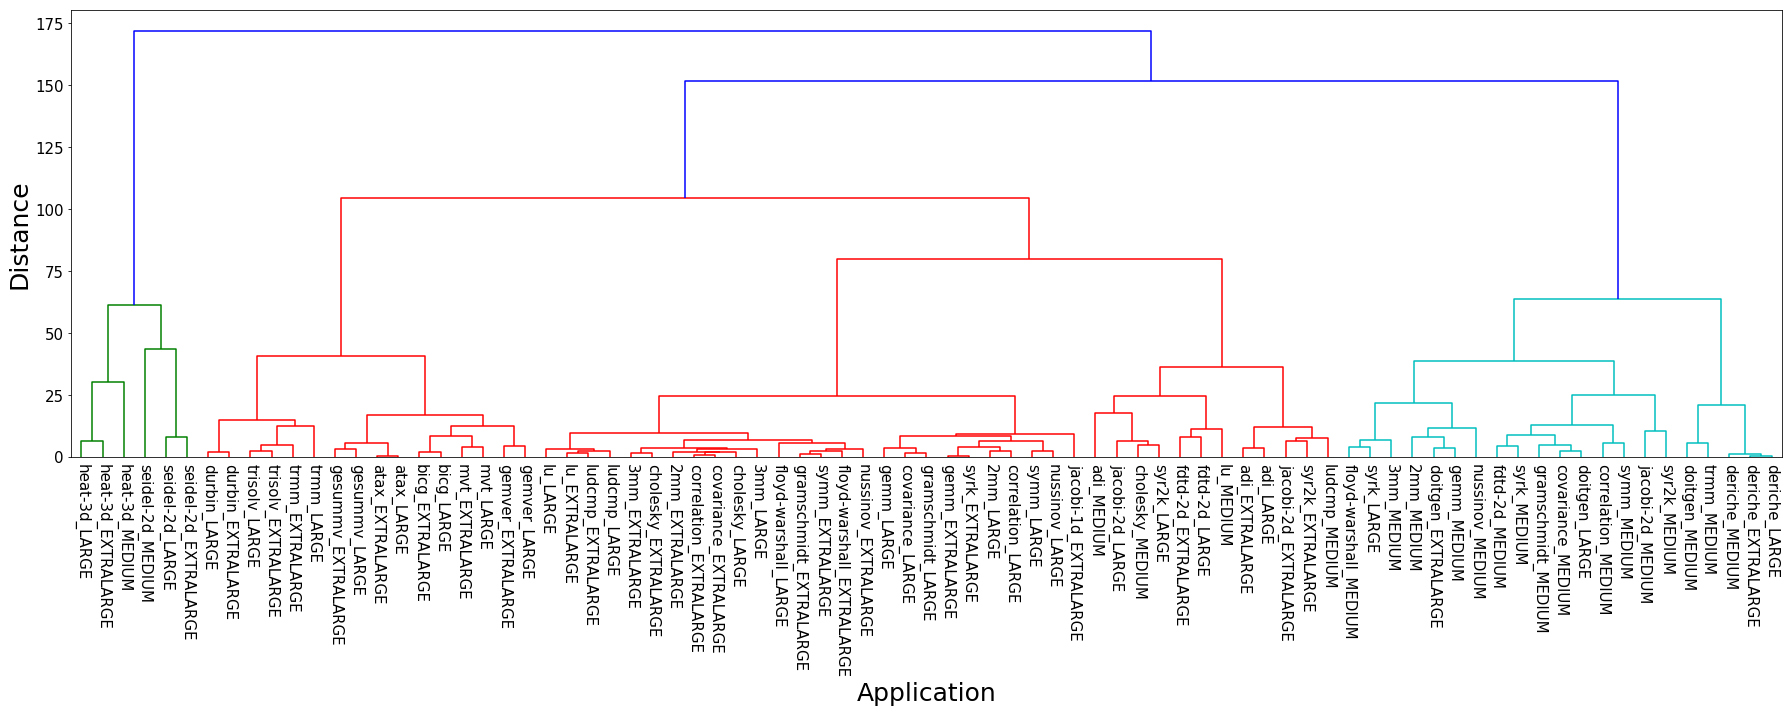

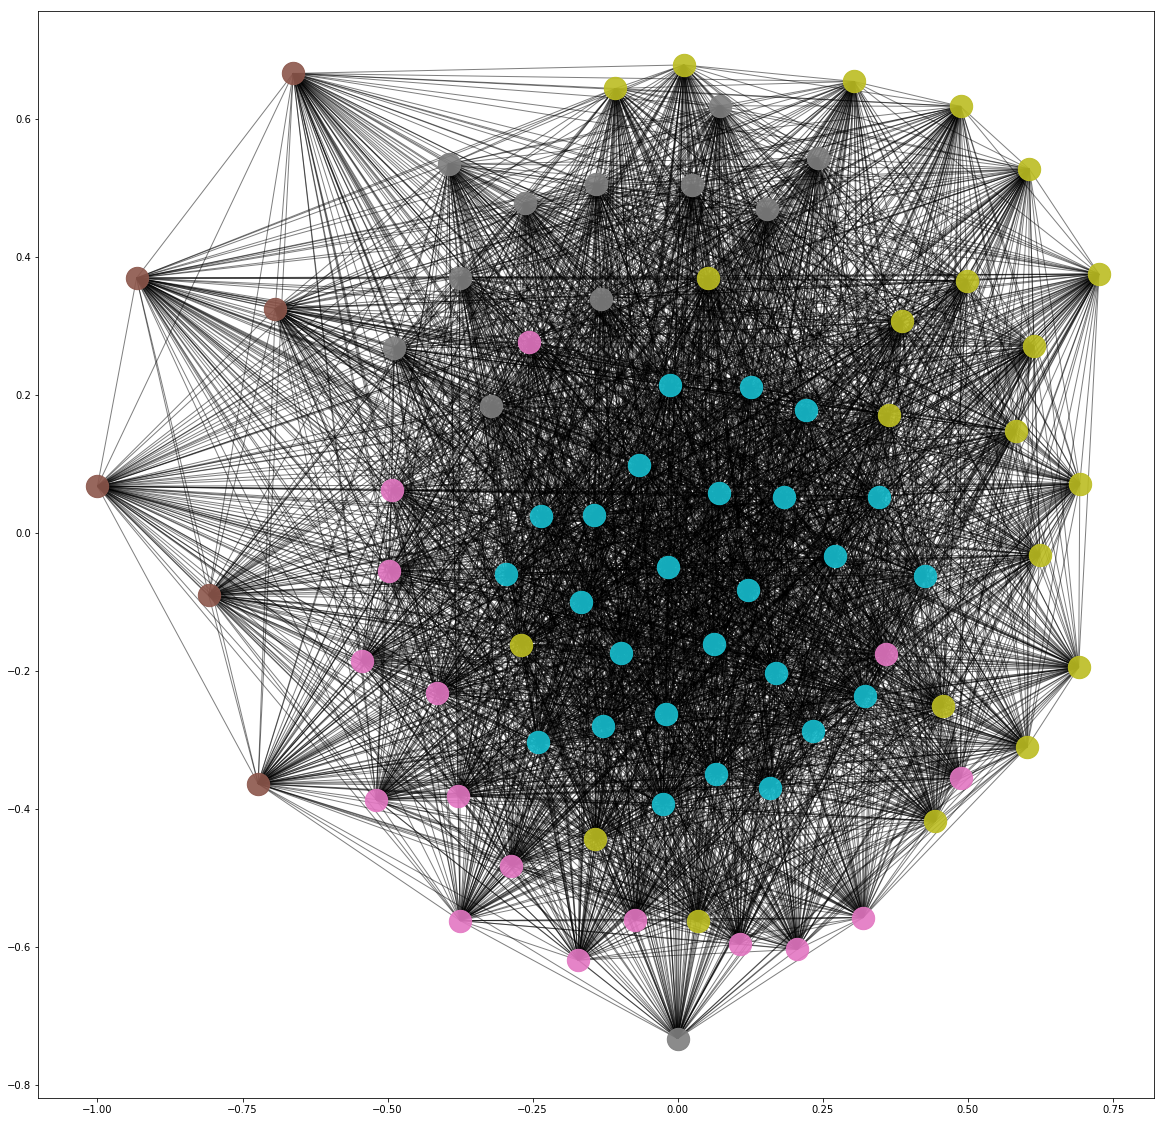

In [171]:
#df= create_df_interpolated('input_size')
#df.to_csv('inputs_all.csv')
df= pd.read_csv("inputs_all.csv",index_col=0).T
best= find_best_cluster(df)
Z= best['Z']
pdic= best['pdic']

plot_dendogram(Z, df.index.str.replace('_DATASET_mem.dat',''))
plt.tight_layout()
#plt.savefig('dendograma_input_size.png')
plot_graph(best)
#plt.savefig('graph_input_size.png')

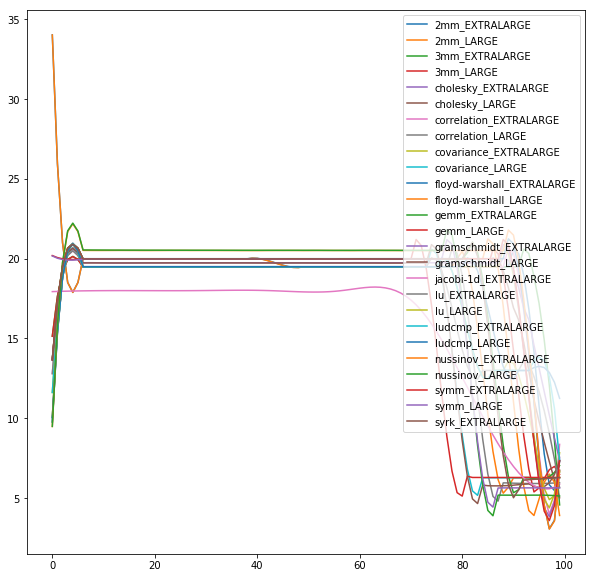

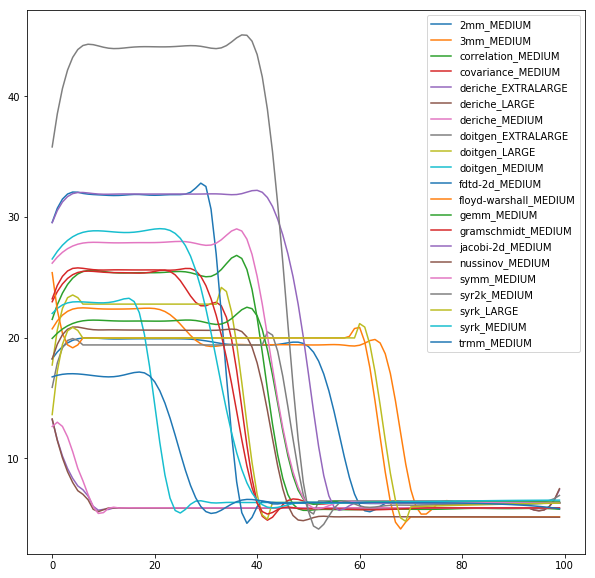

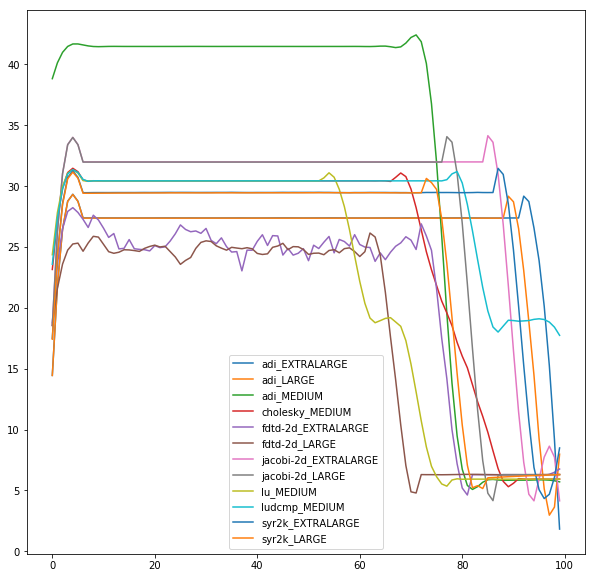

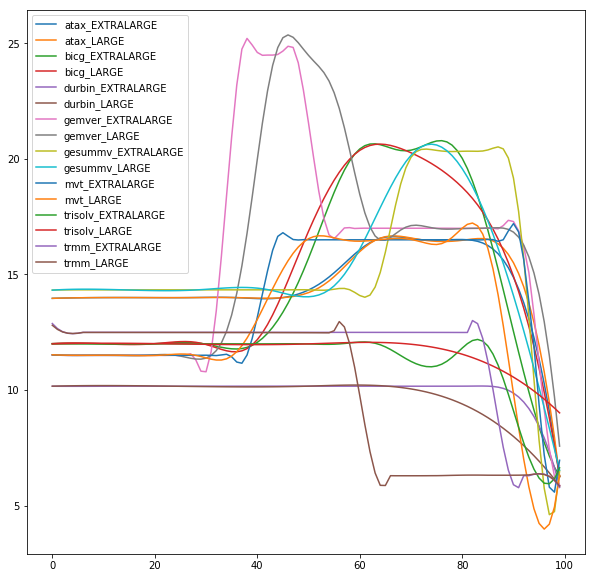

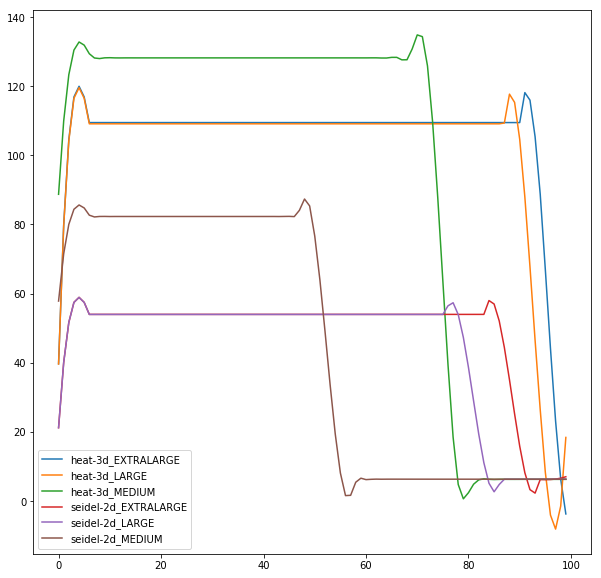

In [172]:
labels= sch.fcluster(best['Z'],t=best['nc'],criterion='maxclust')
pdic= defaultdict(list)
for l, p in zip(labels, df.index):
    #pdic[l].append(p.replace('_DATASET_mem.dat',''))
    pdic[l].append(p)

aux= df
aux.index= aux.index.str.replace('_DATASET_mem.dat','')
aux= aux.T
for c, (k, p) in enumerate(pdic.items()):
    x= [x.replace('_DATASET_mem.dat','') for x in p]
    aux[x].plot(figsize=(10,10))
    plt.savefig('cluster_input_{}'.format(c))

# Clusterization by floating point operation

braycurtis single 2 0.6216216216216216
braycurtis single 7 0.6229508196721312
braycurtis complete 2 0.6363636363636364
braycurtis complete 4 0.6585365853658537
braycurtis complete 5 0.9583333333333334
braycurtis complete 9 1.4615384615384615
braycurtis ward 9 1.5833333333333333
canberra ward 8 1.7272727272727273


/home/vitor/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


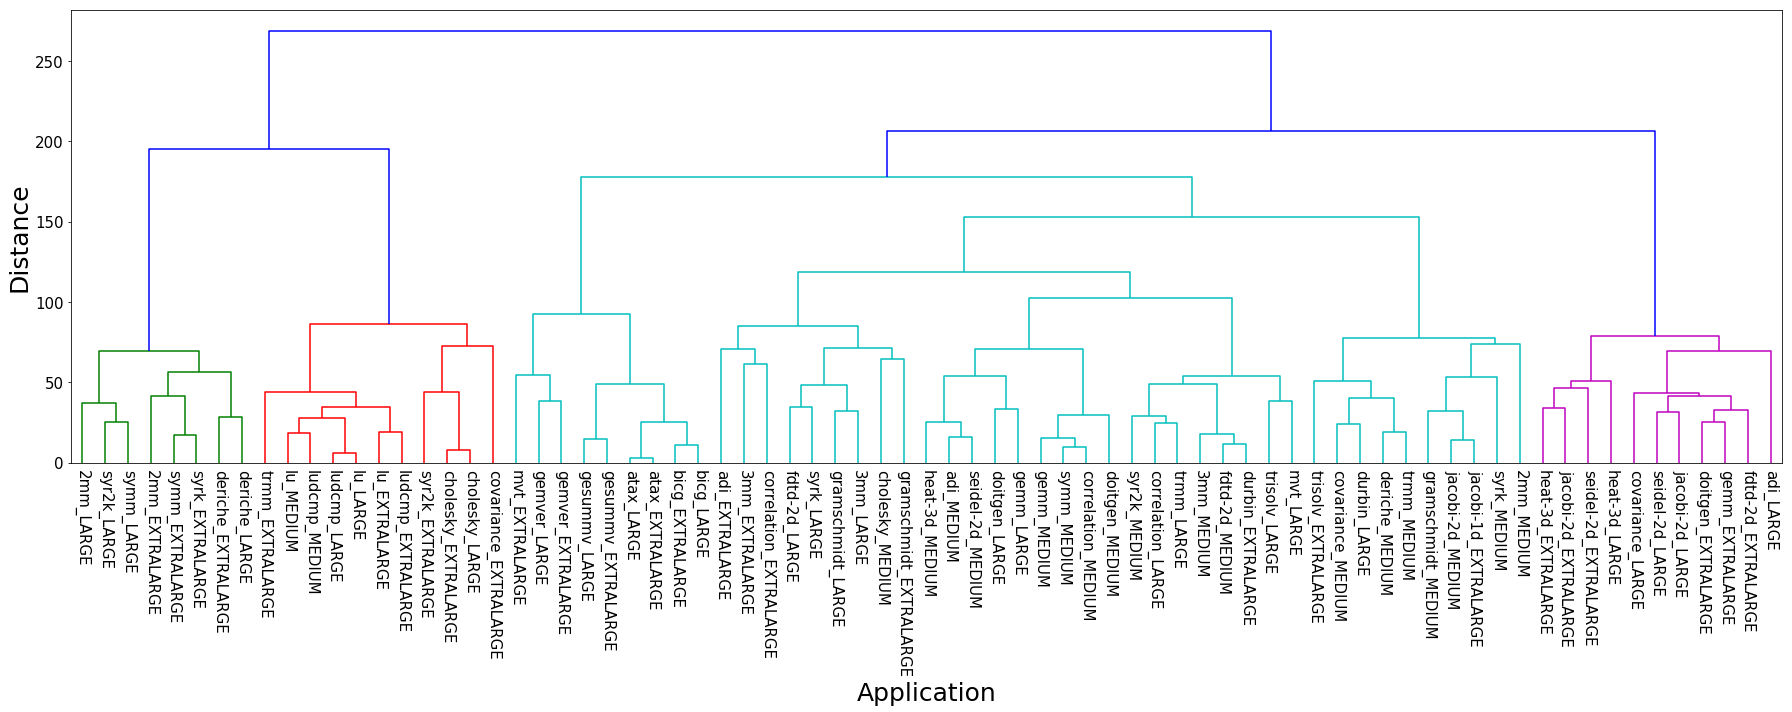

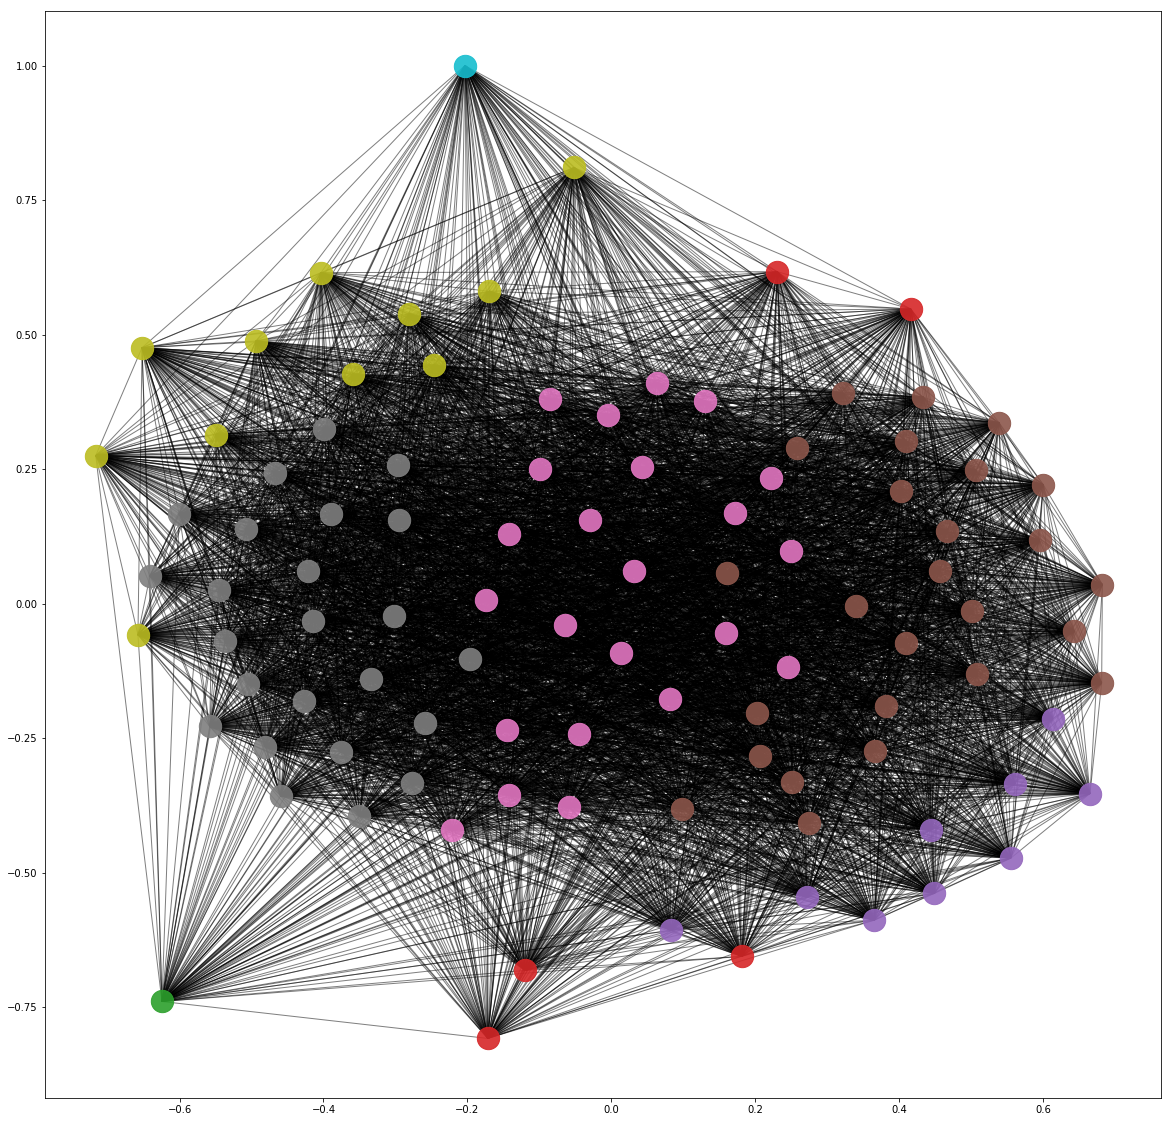

In [170]:
#df= create_df_interpolated('FP_ARITH_INST_RETIRED:SCALAR')
#df.to_csv('fp_all.csv')
df= pd.read_csv("fp_all.csv",index_col=0)
df_norm= (df - df.mean()) / (df.max() - df.min())
df_norm= df_norm.T
best= find_best_cluster(df_norm)
Z= best['Z']
pdic= best['pdic']

plot_dendogram(Z, df_norm.index.str.replace('_DATASET_mem.dat',''))
plt.tight_layout()
#plt.savefig('dendograma_floating.png')
plot_graph(best)
#plt.savefig('graph_floating.png')

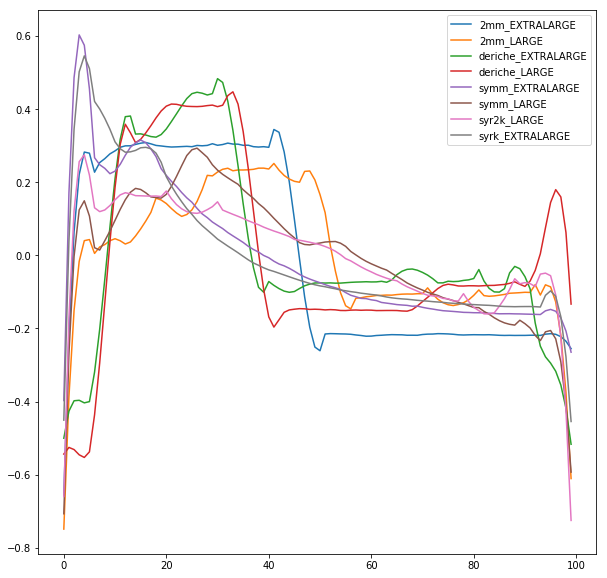

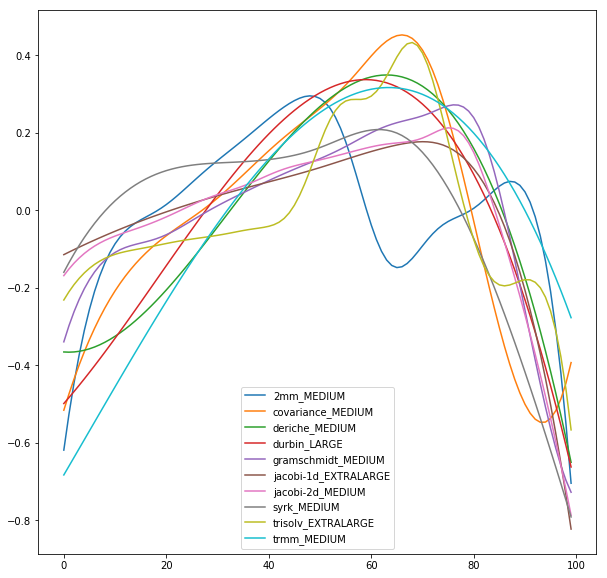

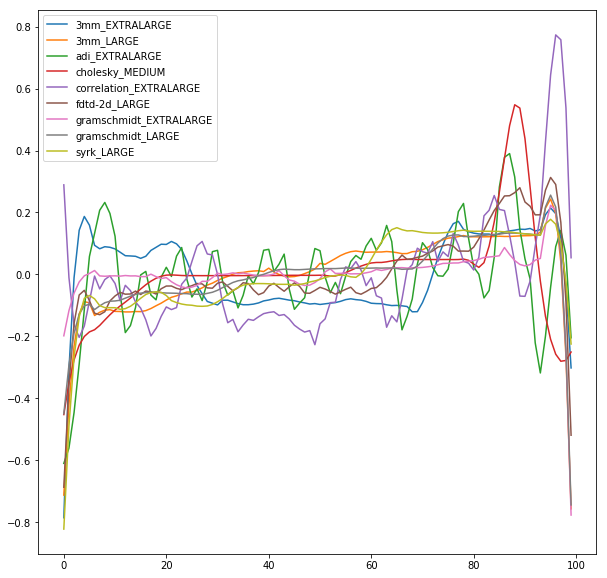

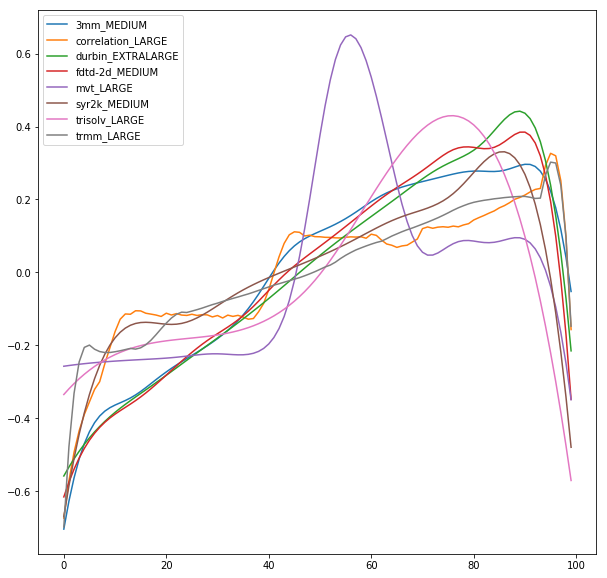

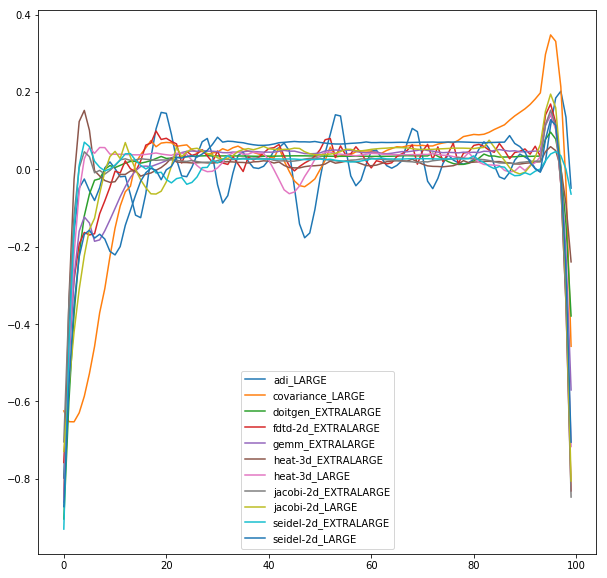

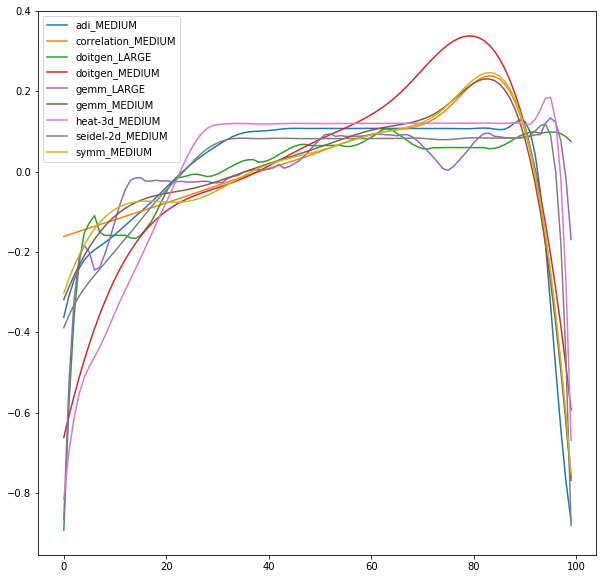

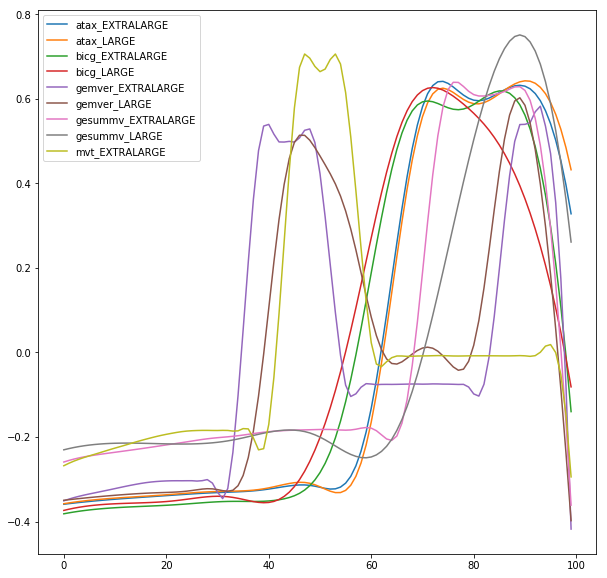

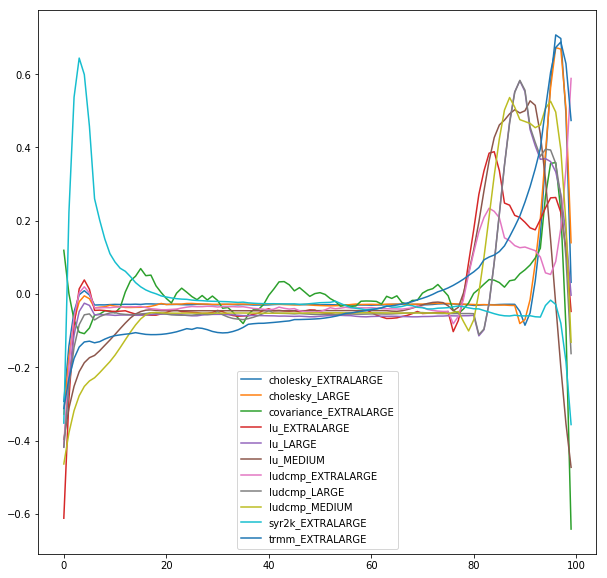

In [169]:
labels= sch.fcluster(best['Z'],t=best['nc'],criterion='maxclust')
pdic= defaultdict(list)
for l, p in zip(labels, df_norm.index):
    #pdic[l].append(p.replace('_DATASET_mem.dat',''))
    pdic[l].append(p)

aux= df_norm
aux.index= aux.index.str.replace('_DATASET_mem.dat','')
aux= aux.T
for c, (k, p) in enumerate(pdic.items()):
    x= [x.replace('_DATASET_mem.dat','') for x in p]
    aux[x].plot(figsize=(10,10))
    plt.savefig('cluster_fp_{}'.format(c))

# Clusterizing by ...

In [ ]:
#df= create_df_interpolated('FP_ARITH_INST_RETIRED:SCALAR')
#df.to_csv('fp_all.csv')
df= pd.read_csv("fp_all.csv",index_col=0)
df_norm= (df - df.mean()) / (df.max() - df.min())
df_norm= df_norm.T
best= find_best_cluster(df_norm)
Z= best['Z']
pdic= best['pdic']

plot_dendogram(Z)
plot_graph(best)